In [1]:
# Cell 1: Import Libraries
import os
import librosa
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
# Cell 2: Define Preprocessing Functions

def normalize_loudness(y):
    """Normalize audio to have consistent loudness."""
    rms = np.sqrt(np.mean(y**2))
    if rms > 0:
        y = y / rms
    return y

def load_and_preprocess_audio(file_path, target_sr=16000):
    """Load and preprocess audio file."""
    y, sr = librosa.load(file_path, sr=None)
    # Downsample if necessary
    if sr != target_sr:
        y = librosa.resample(y, orig_sr=sr, target_sr=target_sr)
    # Normalize loudness
    y = normalize_loudness(y)
    return y

def segment_audio(y, sr, segment_length=3.0, hop_length=1.0):
    """Segment audio into overlapping chunks."""
    segment_samples = int(segment_length * sr)
    hop_samples = int(hop_length * sr)
    segments = []
    for start in range(0, len(y) - segment_samples + 1, hop_samples):
        end = start + segment_samples
        segments.append(y[start:end])
    return segments

def estimate_tempo(y, sr=16000):
    """Estimate the tempo of an audio signal."""
    try:
        tempo, _ = librosa.beat.beat_track(y=y, sr=sr, trim=False)
        if tempo == 0:
            tempo = np.nan  # Handle zero tempo
    except Exception as e:
        print(f"Error estimating tempo: {e}")
        tempo = np.nan
    return tempo


In [4]:
# Cell 3: Load and Process Audio Files

# Path to your dataset folder
dataset_path = '../dataset'

# Get list of audio files
audio_files = [os.path.join(dataset_path, f) for f in os.listdir(dataset_path) if f.endswith('.wav')]

# Preprocess and store audio segments and tempo labels
audio_segments = []
tempo_labels = []

for file in tqdm(audio_files, desc='Loading and preprocessing audio files'):
    y = load_and_preprocess_audio(file)
    segments = segment_audio(y, sr=16000, segment_length=3.0, hop_length=1.0)
    for segment in segments:
        # Estimate tempo for each segment
        tempo = estimate_tempo(segment)
        audio_segments.append(segment)
        tempo_labels.append(tempo)

# Convert tempo_labels to a NumPy array
tempo_labels = np.array(tempo_labels)

# Identify valid indices where tempo is not NaN
valid_indices = ~np.isnan(tempo_labels)

# Filter the audio_segments and tempo_labels
audio_segments = [audio_segments[i] for i in range(len(audio_segments)) if valid_indices[i]]
tempo_labels = tempo_labels[valid_indices]


Loading and preprocessing audio files:   0%|          | 0/615 [00:00<?, ?it/s]

In [5]:
# Cell 4: Define Feature Extraction Function

def extract_features(y, sr=16000):
    """Extract various audio features."""
    # Tempogram features
    oenv = librosa.onset.onset_strength(y=y, sr=sr)
    tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr)
    tempogram_mean = np.mean(tempogram, axis=1)
    
    # MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_mean = np.mean(chroma, axis=1)
    
    # Spectral Contrast
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    contrast_mean = np.mean(contrast, axis=1)
    
    # Concatenate all features
    features = np.concatenate((tempogram_mean, mfcc_mean, chroma_mean, contrast_mean))
    return features




In [6]:
# Cell 5: Extract Features from All Segments

# Extract features for all segments
feature_vectors = []

for y in tqdm(audio_segments, desc='Extracting features'):
    features = extract_features(y)
    feature_vectors.append(features)

# Convert feature_vectors to a NumPy array
feature_vectors = np.array(feature_vectors)


Extracting features:   0%|          | 0/5638 [00:00<?, ?it/s]

In [7]:
# Cell 6: Normalize Features

# Normalize features
feature_mean = np.mean(feature_vectors, axis=0)
feature_std = np.std(feature_vectors, axis=0)
feature_std[feature_std == 0] = 1e-6  # Avoid division by zero
feature_vectors_normalized = (feature_vectors - feature_mean) / feature_std

# Add a print statement to confirm variable creation
print("Feature vectors normalized shape:", feature_vectors_normalized.shape)


Feature vectors normalized shape: (5638, 416)


In [8]:
# Cell 7: Normalize Tempo Labels

# Compute the maximum tempo value
max_tempo = np.max(tempo_labels)

# Normalize tempo labels
tempo_labels_normalized = tempo_labels / max_tempo


In [9]:
# Cell 8: Create a Custom Dataset

from torch.utils.data import Dataset, DataLoader

class TempoDataset(Dataset):
    def __init__(self, feature_vectors, tempo_labels):
        self.feature_vectors = torch.tensor(feature_vectors).float()
        self.tempo_labels = torch.tensor(tempo_labels).float()

    def __len__(self):
        return len(self.feature_vectors)

    def __getitem__(self, idx):
        return self.feature_vectors[idx], self.tempo_labels[idx]


In [10]:
# Cell 9: Split Dataset

from sklearn.model_selection import train_test_split

# Use normalized features and labels
train_features, val_features, train_labels, val_labels = train_test_split(
    feature_vectors_normalized, tempo_labels_normalized, test_size=0.2, random_state=42)


# Cell 10: Create DataLoaders

# Create DataLoaders
train_dataset = TempoDataset(train_features, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

val_dataset = TempoDataset(val_features, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)


In [11]:
# Cell 11: Define the Regression Model

import torch.nn as nn

class TempoRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TempoRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.sigmoid = nn.Sigmoid()  # Output between 0 and 1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x.squeeze()


In [12]:
# Cell 12: Initialize the Model

# Define input_size and hidden_size based on the new feature vector size
input_size = feature_vectors_normalized.shape[1]  # Number of features
hidden_size = 128  # Adjusted hidden size

model = TempoRegressor(input_size, hidden_size)


In [13]:
# Cell 13: Define Loss Function and Optimizer

import torch.optim as optim

criterion = nn.L1Loss()  # Using Mean Absolute Error loss
optimizer = optim.Adam(model.parameters(), lr=0.0001)  # Reduced learning rate


!!!!! OPTIONAL !!!! 


Resume Training form a previously saved model. (This means you need to run step 7 at least one time before)




In [49]:
# Cell Before: Load the Best Model

import torch

# Ensure the model class TempoRegressor is defined
# and input_size, hidden_size are set

# Initialize the model
model = TempoRegressor(input_size, hidden_size)
model.to(device)

# Load the best model
checkpoint_dir = 'checkpoints_04'  # Update as needed
best_model_path = os.path.join(checkpoint_dir, 'best_tempo_model_06_speed.pth')
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

print("Best model loaded successfully for evaluation.")


Best model loaded successfully for evaluation.


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_16769/1124066247.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_

Epoch 1/50: 100%|██████████| 141/141 [00:00<00:00, 2091.65it/s]


Epoch [1/50], Train Loss: 0.0661, Val Loss: 0.0739
Best model saved with validation loss: 0.0739


Epoch 2/50: 100%|██████████| 141/141 [00:00<00:00, 1819.76it/s]


Epoch [2/50], Train Loss: 0.0653, Val Loss: 0.0739
No improvement in validation loss for 1 epoch(s).


Epoch 3/50: 100%|██████████| 141/141 [00:00<00:00, 2544.44it/s]


Epoch [3/50], Train Loss: 0.0649, Val Loss: 0.0739
No improvement in validation loss for 2 epoch(s).


Epoch 4/50: 100%|██████████| 141/141 [00:00<00:00, 2566.72it/s]


Epoch [4/50], Train Loss: 0.0652, Val Loss: 0.0739
No improvement in validation loss for 3 epoch(s).


Epoch 5/50: 100%|██████████| 141/141 [00:00<00:00, 2345.43it/s]


Epoch [5/50], Train Loss: 0.0658, Val Loss: 0.0739
No improvement in validation loss for 4 epoch(s).


Epoch 6/50: 100%|██████████| 141/141 [00:00<00:00, 2555.41it/s]


Epoch [6/50], Train Loss: 0.0652, Val Loss: 0.0739
No improvement in validation loss for 5 epoch(s).


Epoch 7/50: 100%|██████████| 141/141 [00:00<00:00, 2596.59it/s]


Epoch [7/50], Train Loss: 0.0653, Val Loss: 0.0739
No improvement in validation loss for 6 epoch(s).


Epoch 8/50: 100%|██████████| 141/141 [00:00<00:00, 2603.83it/s]


Epoch [8/50], Train Loss: 0.0652, Val Loss: 0.0739
No improvement in validation loss for 7 epoch(s).


Epoch 9/50: 100%|██████████| 141/141 [00:00<00:00, 2576.75it/s]


Epoch [9/50], Train Loss: 0.0655, Val Loss: 0.0739
No improvement in validation loss for 8 epoch(s).


Epoch 10/50: 100%|██████████| 141/141 [00:00<00:00, 2046.38it/s]


Epoch [10/50], Train Loss: 0.0659, Val Loss: 0.0739
No improvement in validation loss for 9 epoch(s).


Epoch 11/50: 100%|██████████| 141/141 [00:00<00:00, 1337.85it/s]


Epoch [11/50], Train Loss: 0.0655, Val Loss: 0.0739
No improvement in validation loss for 10 epoch(s).
Early stopping triggered.


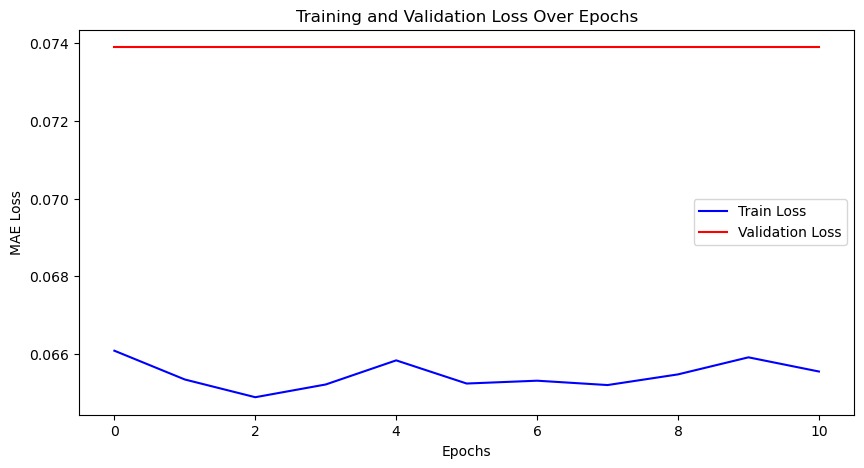

In [50]:
# Cell 14: Train the Model

import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Ensure 'checkpoint_dir' is defined
checkpoint_dir = 'checkpoints_04'  # Update as needed
os.makedirs(checkpoint_dir, exist_ok=True)

# Check if a GPU is available and set device accordingly
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Initialize lists to store losses
train_losses = []
val_losses = []

# Set the number of epochs and early stopping parameters
num_epochs = 50
patience = 10
best_val_loss = float('inf')
counter = 0

for epoch in range(num_epochs):
    model.train()
    train_loss = 0

    for batch_data, batch_labels in tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)

        # Forward pass
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0

    with torch.no_grad():
        for val_data, val_labels in val_dataloader:
            val_data = val_data.to(device)
            val_labels = val_labels.to(device)

            outputs = model(val_data)
            loss = criterion(outputs, val_labels)

            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Early Stopping and Checkpoint Saving
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        # Save only the model's state_dict
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, 'best_tempo_model_06_speed.pth'))
        print(f"Best model saved with validation loss: {best_val_loss:.4f}")
        counter = 0
    else:
        counter += 1
        print(f"No improvement in validation loss for {counter} epoch(s).")
        if counter >= patience:
            print("Early stopping triggered.")
            break

# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss", color="blue")
plt.plot(val_losses, label="Validation Loss", color="red")
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('MAE Loss')
plt.legend()
plt.show()


Step 8: Analyze the Learned Representations
8.1: Extract Latent Features from the training data

Mean Absolute Error in Tempo Estimation: 23.84 BPM


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_16769/1784243112.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tempo_

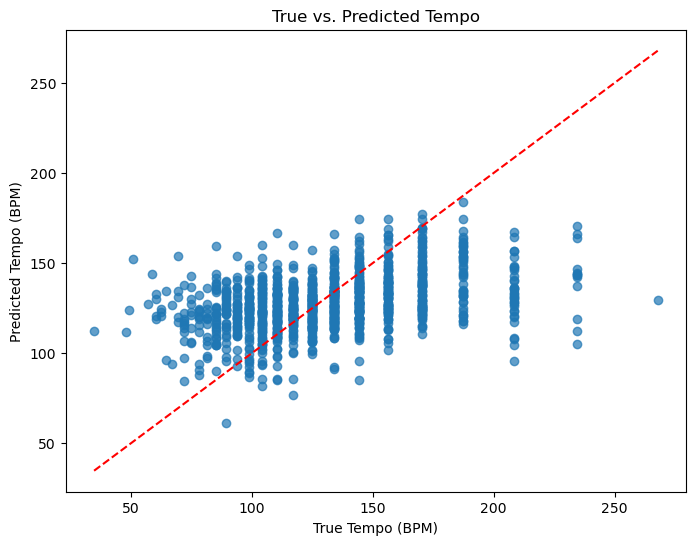

In [51]:
# Cell 15: Evaluate the Model

from sklearn.metrics import mean_absolute_error

# Load the best model
model.load_state_dict(torch.load('best_tempo_model_06_speed.pth'))
model.to(device)
model.eval()

true_tempos = []
predicted_tempos = []

with torch.no_grad():
    for val_data, val_labels in val_dataloader:
        val_data = val_data.to(device)
        val_labels = val_labels.to(device)

        outputs = model(val_data)

        # Collect true and predicted tempos
        true_tempos.extend(val_labels.cpu().numpy())
        predicted_tempos.extend(outputs.cpu().numpy())

# Rescale predictions and true labels back to original tempo range
true_tempos_rescaled = [t * max_tempo for t in true_tempos]
predicted_tempos_rescaled = [p * max_tempo for p in predicted_tempos]

# Compute Mean Absolute Error
mae = mean_absolute_error(true_tempos_rescaled, predicted_tempos_rescaled)
print(f"Mean Absolute Error in Tempo Estimation: {mae:.2f} BPM")

# Plot true vs. predicted tempos
plt.figure(figsize=(8, 6))
plt.scatter(true_tempos_rescaled, predicted_tempos_rescaled, alpha=0.7)
plt.plot([min(true_tempos_rescaled), max(true_tempos_rescaled)],
         [min(true_tempos_rescaled), max(true_tempos_rescaled)], 'r--')
plt.xlabel('True Tempo (BPM)')
plt.ylabel('Predicted Tempo (BPM)')
plt.title('True vs. Predicted Tempo')
plt.show()


Transform to Tensorflow (Change Kernel to ts_onnx or so)

In [14]:
import torch.nn as nn

class TempoRegressor(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(TempoRegressor, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.fc3 = nn.Linear(hidden_size // 2, 1)
        self.sigmoid = nn.Sigmoid()  # Output between 0 and 1

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x.squeeze()


In [15]:
input_size = feature_vectors_normalized.shape[1]  # Based on your feature size
hidden_size = 128  # You can adjust this based on your preference


In [16]:
import torch
import onnx

# Load your trained model
model = TempoRegressor(input_size, hidden_size)
model.load_state_dict(torch.load('best_tempo_model_06_speed.pth'))
model.eval()

# Dummy input for the model (size should match the input size of your model)
dummy_input = torch.randn(1, input_size)

# Export the model to ONNX
torch.onnx.export(model, dummy_input, "tempo_model.onnx", opset_version=11)


/var/folders/5k/5lwm6jlm8xjb4h00r6bnjs280000gn/T/ipykernel_74546/3348742585.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_tempo_

CHANGE KERNEL HERE TO ONX KERNEL

In [1]:
pip install tensorflow==2.15.0


  Using cached tensorboard-2.15.2-py3-none-any.whl.metadata (1.7 kB)
  Using cached tensorflow_estimator-2.15.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
  Using cached google_auth-2.35.0-py2.py3-none-any.whl.metadata (4.7 kB)
  Using cached google_auth_oauthlib-1.2.1-py2.py3-none-any.whl.metadata (2.7 kB)
  Using cached cachetools-5.5.0-py3-none-any.whl.metadata (5.3 kB)
  Using cached pyasn1_modules-0.4.1-py3-none-any.whl.metadata (3.5 kB)
  Using cached rsa-4.9-py3-none-any.whl.metadata (4.2 kB)
  Using cached requests_oauthlib-2.0.0-py2.py3-none-any.whl.metadata (11 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached oauthlib-3.2.2-py3-none-any.whl.metadata (7.5 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 MB 40.1 MB/s eta 0:00:0000:0100:01
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 30.4 MB/s eta 0:00:00
Using cache

In [2]:
pip install tensorflow-addons==0.20.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 8.6 MB/s eta 0:00:0000:010:01m
  Attempting uninstall: tensorflow-addons
    Found existing installation: tensorflow-addons 0.23.0
    Uninstalling tensorflow-addons-0.23.0:
      Successfully uninstalled tensorflow-addons-0.23.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
from onnx_tf.backend import prepare
import onnx

# Load the ONNX model
onnx_model = onnx.load("tempo_model.onnx")

# Convert to TensorFlow
tf_rep = prepare(onnx_model)

# Export the model as a TensorFlow SavedModel format
tf_rep.export_graph("tempo_model_saved_model")


ModuleNotFoundError: No module named 'tensorflow.python.client'